🚀 Connecting to Satellite Database...
📅 Found 11 scenes. Analyzing river health...
  [1/11] Processing 2023-01-01... ✅ River Turbidity: -0.008
  [2/11] Processing 2023-01-16... ✅ River Turbidity: -0.015
  [3/11] Processing 2023-02-10... ✅ River Turbidity: -0.019
  [4/11] Processing 2023-02-10... ✅ River Turbidity: -0.018
  [5/11] Processing 2023-04-11... ✅ River Turbidity: -0.021
  [6/11] Processing 2023-04-11... ✅ River Turbidity: -0.021
  [7/11] Processing 2023-04-21... ✅ River Turbidity: -0.027
  [8/11] Processing 2023-04-21... ✅ River Turbidity: -0.027
  [9/11] Processing 2023-06-30... ✅ River Turbidity: -0.048
  [10/11] Processing 2023-12-17... ✅ River Turbidity: 0.002
  [11/11] Processing 2023-12-22... ✅ River Turbidity: -0.018


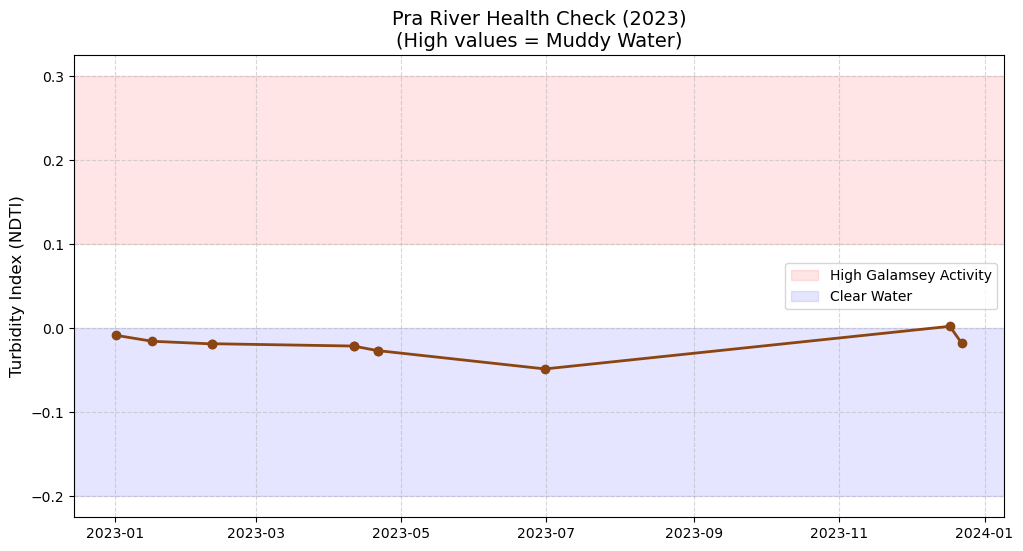

📊 Success! Trend graph saved as Pra_River_2023_Trend.png


In [2]:
import pystac_client
import planetary_computer
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# We define everything here so nothing gets lost
AOI_BBOX = [-1.62, 5.05, -1.55, 5.15]  # The Pra River Box
DATE_RANGE = "2023-01-01/2023-12-31"   # Full Year 2023

print("🚀 Connecting to Satellite Database...")

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)


search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=AOI_BBOX,
    datetime=DATE_RANGE,
    query={"eo:cloud_cover": {"lt": 20}}, # Allow <20% clouds
)

# Get items and sort them by date
items = search.item_collection()
items = sorted(items, key=lambda i: i.properties["datetime"])

print(f"📅 Found {len(items)} scenes. Analyzing river health...")

results = []


for i, item in enumerate(items):
    date = item.datetime
    date_str = date.strftime('%Y-%m-%d')
    print(f"  [{i+1}/{len(items)}] Processing {date_str}...", end=" ")
    
    try:
        # Get URLs for Red, Green, and NIR (Near Infrared)
        href_red = item.assets["B04"].href
        href_green = item.assets["B03"].href
        href_nir = item.assets["B08"].href

        # Stream the data (Downsampled 8x for speed)
        with rasterio.open(href_red) as src:
            red = src.read(1, out_shape=(src.height // 8, src.width // 8))
        with rasterio.open(href_green) as src:
            green = src.read(1, out_shape=(src.height // 8, src.width // 8))
        with rasterio.open(href_nir) as src:
            nir = src.read(1, out_shape=(src.height // 8, src.width // 8))

        
        np.seterr(divide='ignore', invalid='ignore')
        
        # Convert to float
        r, g, n = red.astype(float), green.astype(float), nir.astype(float)

        # Turbidity Index (NDTI)
        ndti = (r - g) / (r + g)
        
        # Water Mask (NDWI) - Used to find the river
        ndwi = (g - n) / (g + n)

   
        # We only look at pixels where NDWI > 0 (Water)
        # This ignores the forest and clouds
        river_pixels = ndti[ndwi > 0.0]
        
        if len(river_pixels) > 500: # Ensure we have enough water pixels to be sure
            avg_turbidity = np.nanmean(river_pixels)
            results.append({"Date": date, "Turbidity": avg_turbidity})
            print(f"✅ River Turbidity: {avg_turbidity:.3f}")
        else:
            print(f"⚠️ Cloud/Land obscured.")

    except Exception as e:
        print(f" Error: {e}")


if results:
    df = pd.DataFrame(results)
    
    plt.figure(figsize=(12, 6))
    
    # Plot the line
    plt.plot(df["Date"], df["Turbidity"], marker='o', linestyle='-', color='#8B4513', linewidth=2)
    
    # Add a "Danger Zone" background
    plt.axhspan(0.1, 0.3, color='red', alpha=0.1, label='High Galamsey Activity')
    plt.axhspan(-0.2, 0.0, color='blue', alpha=0.1, label='Clear Water')
    
    plt.title("Pra River Health Check (2023)\n(High values = Muddy Water)", fontsize=14)
    plt.ylabel("Turbidity Index (NDTI)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    filename = "Pra_River_2023_Trend.png"
    plt.savefig(filename)
    plt.show()
    print(f"📊 Success! Trend graph saved as {filename}")
else:
    print("No valid data found to plot.")